In [1]:
from sklearn import preprocessing
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.utils import compute_sample_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, average_precision_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 
import optuna

In [2]:
data = pd.read_csv("Creditcard.csv")
data.tail()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:

X = data.drop(columns=["Class"])
y = data["Class"]

# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train/validation split within trainingset
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)


def maak_pu_setting(y_true, label_ratio, random_state=42):
    np.random.seed(random_state)
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)
    
    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1
    
    return y_pu, y_true, gelabelde_indexen

y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting(y_train_true, label_ratio=0.2)




In [7]:
print(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

In [8]:
def objective(trial):
    C = trial.suggest_float("C", 0.01, 100.0, log=True)

    model = LogisticRegression(
        C=C,
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=1000
    )

    # Train on PU-labels
    model.fit(X_train, y_train_pu)


    y_val_pred = model.predict(X_val)

    score = f1_score(y_val_true, y_val_pred)

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=300)

print("Beste parameters:", study.best_params)
print("Beste F1-score (CV):", study.best_value)

# Train with the beste model
best_model = LogisticRegression(
    C=study.best_params['C'],
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000
)
best_model.fit(X_train, y_train_pu)
y_probs = best_model.predict_proba(X_test)[:, 1] 


# generating a list of thresholds from 0.0 to 1.0 in steps of 0.05
thresholds = np.arange(0.0, 1.05, 0.05)


best_threshold = 0
best_f1 = 0
f1_scores = []
pr_auc_scores = []

for threshold in thresholds:
    y_pred_custom = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_custom)
    pr_auc = average_precision_score(y_test, y_pred_custom)
    f1_scores.append(f1)
    pr_auc_scores.append(pr_auc)
    
    # Check whether this threshold is better than current best
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold


[I 2025-05-13 20:56:53,919] A new study created in memory with name: no-name-9bbecff2-da00-4f37-90b6-923cdca45488
[I 2025-05-13 20:56:55,249] Trial 0 finished with value: 0.1126005361930295 and parameters: {'C': 0.08416327691705439}. Best is trial 0 with value: 0.1126005361930295.
[I 2025-05-13 20:56:58,609] Trial 1 finished with value: 0.09143686502177069 and parameters: {'C': 0.6509360602636427}. Best is trial 0 with value: 0.1126005361930295.
[I 2025-05-13 20:56:59,804] Trial 2 finished with value: 0.1126005361930295 and parameters: {'C': 0.5846176293898703}. Best is trial 0 with value: 0.1126005361930295.
[I 2025-05-13 20:57:00,993] Trial 3 finished with value: 0.1126005361930295 and parameters: {'C': 0.5917049671806798}. Best is trial 0 with value: 0.1126005361930295.
[I 2025-05-13 20:57:02,975] Trial 4 finished with value: 0.10714285714285715 and parameters: {'C': 61.25453169310957}. Best is trial 0 with value: 0.1126005361930295.
[I 2025-05-13 20:57:04,162] Trial 5 finished with

[I 2025-05-13 20:58:34,176] Trial 48 finished with value: 0.10787671232876712 and parameters: {'C': 0.014285734025986097}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 20:58:35,909] Trial 49 finished with value: 0.11320754716981132 and parameters: {'C': 0.02247715695113403}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 20:58:38,122] Trial 50 finished with value: 0.1070518266779949 and parameters: {'C': 0.03840299765116447}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 20:58:39,309] Trial 51 finished with value: 0.11361587015329125 and parameters: {'C': 0.01010573307313009}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 20:58:40,570] Trial 52 finished with value: 0.11330935251798561 and parameters: {'C': 0.010396201970941045}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 20:58:41,783] Trial 53 finished with value: 0.11320754716981132 and parameters: {'C': 0.015055004045064775}. Best is trial 31

[I 2025-05-13 21:00:04,473] Trial 96 finished with value: 0.0942408376963351 and parameters: {'C': 0.010133456534556896}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 21:00:06,112] Trial 97 finished with value: 0.10787671232876712 and parameters: {'C': 0.015383211121178868}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 21:00:08,447] Trial 98 finished with value: 0.09326424870466321 and parameters: {'C': 0.019702415890439803}. Best is trial 31 with value: 0.11567164179104478.
[I 2025-05-13 21:00:09,730] Trial 99 finished with value: 0.11341134113411341 and parameters: {'C': 0.012303773713931657}. Best is trial 31 with value: 0.11567164179104478.


Beste parameters: {'C': 0.012114255216148234}
Beste F1-score (CV): 0.11567164179104478


Beste threshold: 0.9500000000000001
Accuracy: 0.9963367391126248
Precision: 0.2932330827067669
Recall: 0.7905405405405406
F1-score: 0.42778793418647165
ROC AUC: 0.9125387565888181
PR AUC (beste threshold): 0.23217545468344244


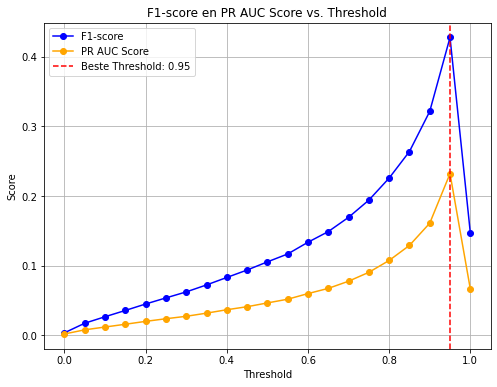

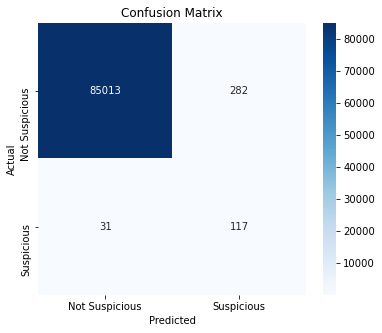

In [9]:
#best parameter {'C': 0.012114255216148234}
# predictions with best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)

# Evaluation
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_probs)
pr_auc_best = average_precision_score(y_test, y_pred_best)


print(f"Beste threshold: {best_threshold}")
print(f"Accuracy: {accuracy_best}")
print(f"Precision: {precision_best}")
print(f"Recall: {recall_best}")
print(f"F1-score: {f1_best}")
print(f"ROC AUC: {roc_auc_best}")
print(f"PR AUC (beste threshold): {pr_auc_best}")

# F1-score and PR AUC versus Thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', label="F1-score", color='blue')
plt.plot(thresholds, pr_auc_scores, marker='o', linestyle='-', label="PR AUC Score", color='orange')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Beste Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1-score en PR AUC Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()


# Confusion matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

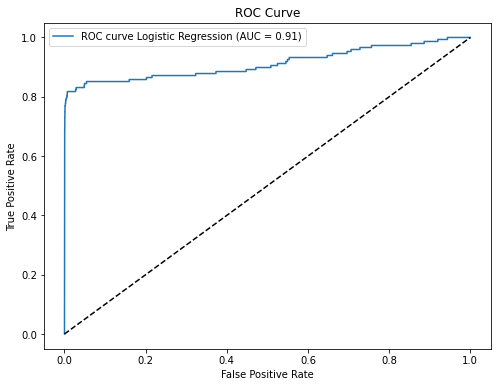

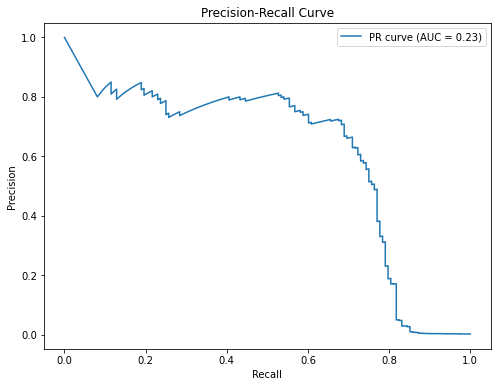

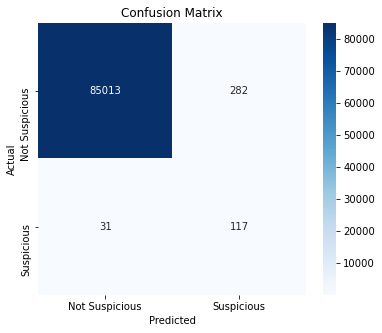

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve Logistic Regression (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale lijn (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve 
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc_best:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

fpr_pu, tpr_pu, _ = roc_curve(y_test, y_probs)
auc_pu = roc_auc_score(y_test, y_probs)

np.savez("roc_LR(FRAUDE).npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_probs)


In [14]:
np.save("preds_LR(FRAUDE).npy", y_pred_best)